#Arabic Sentiment Analysis using different version of BERT 
( Fast AraBert, MarBert and AraBert ) and Transfer learning of Fast Arabert to Saudi Tweet


Device GPU or CPU ?

In [4]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    # !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Install Requirements

In [5]:
!pip install  emoji==1.7
!git clone https://github.com/aub-mind/arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'arabert' already exists and is not an empty directory.


In [6]:
!pip install PyArabic farasapy fast-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import emoji
import regex 
import pandas as pd
import numpy as np
import os, re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel,AutoTokenizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,mean_squared_error
from arabert.preprocess import ArabertPreprocessor




#Read Data

In [8]:
# Training Data
file1 = open('/SemEval2017-task4-train.subtask-A.arabic.txt','r')
train_file= file1.readlines()
print('Train Data \n',train_file[0])
#
# Validation Data
file3 = open('/SemEval2017-task4-dev.subtask-A.arabic.INPUT VALIDATION.txt','r')
validation_file= file3.readlines()
print('validation Data \n',validation_file[0])

Train Data 
 783555835494592513	positive	"إجبار أبل على التعاون على فك شفرة اجهزتها https://t.co/bBRbxNe6qP"

validation Data 
 781400143144726529	positive	"إطلالة أنيقة وانثوية من مجموعة غوتشي لخريف/شتاء 2016 https://t.co/2MG7282hjh https://t.co/9p5a6bIAk7"



# Preprocessing





##Clean Up Data

In [9]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

def Preprocessing(data):
  text = []
  type_of_emotion = []
  for j in range(1,len(data)):  
   dt = data[j].split('\t')
   line = dt[2]
  # emojis = split_count(line)
    
  # for em in emojis : 
  #   line = re.sub(em,'',line)
  
   line = re.sub('[0-9@]', '',line)
   line = re.sub('[/:\.»«]', '',line) # remove \.»«
   line = re.sub('[a-zA-z]', '',line)
   line = re.sub('[#[]', '',line)
   line = re.sub(']', '',line)
   line = line.rstrip().lstrip()
   text.append(line)
   type_of_emotion.append(dt[1])
  return text, type_of_emotion

In [10]:
train_text, train_Label = Preprocessing (train_file)
val_text, val_Label = Preprocessing (validation_file)
print('Data After Cleaning\n',train_text[0])
print(val_text[0])

Data After Cleaning
 "  غوغل تتحدى أبل وأمازون بأجهزة جديدة "
"أخر صيحة من حقائب اليد من فندي وغوتشي فندي غوتشي بناتالخبر"





##Data Segmentation 

### Before Segmenation 

In [11]:
# Create Data Frame
from sklearn.model_selection import train_test_split
X_train, X_Test, y_train, y_Test =train_test_split(train_text, train_Label, test_size=0.2, random_state=42)
# 
train_data = pd.DataFrame(data={'text':X_train,'label':y_train})
# 
test_data = pd.DataFrame(data={'text':X_Test,'label':y_Test})
# 
val_data = pd.DataFrame(data={'text':val_text,'label':val_Label})
# 
train_data.head()

,text,label
0,""" تحديث كبير قادم لبرنامج (الرسام) لنظام وين...",positive
1,"""موقع لمعرفة جميع الأوامر الصوتية في غوغل ناو""",neutral
2,"""كيف تحمي هاتفك الذكي بنظام أندرويد من القرصنة...",positive
3,""" فيديو بثه إعلام الأسدقوات الأسد في حلب برفق...",negative
4,""" ترى نسونجي اوباما ادكر بعزا نلسون منديلا نسى...",negative


In [12]:
test_data.head()

,text,label
0,"""اردوغان قال لروتانا لااستطيع تأيد الانقلاب فى...",negative
1,""" إيرانالتربويون يحتجون في اليومالعالميللمعلم...",negative
2,""" سورياريفدمشقهجوم جديد يشنه تنظيمالدولة يسته...",negative
3,"""ترامب حاول يبرر فضيحته ب ان بيل كلنتون فضيحته...",neutral
4,"""سورية لافروف وظريف يدعوان لحل سياسي ونصرالله ...",neutral


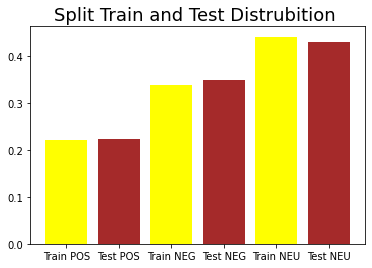

In [13]:
Class = ['Train POS','Test POS','Train NEG','Test NEG','Train NEU','Test NEU']
total = y_train.count('positive')
Class_size = [y_train.count('positive')/len(y_train),y_Test.count('positive')/len(y_Test),
        y_train.count('negative')/len(y_train) ,y_Test.count('negative')/len(y_Test),
        y_train.count('neutral')/len(y_train) ,y_Test.count('neutral')/len(y_Test)]
plt.bar(Class, Class_size, color=['yellow','brown','yellow','brown','yellow','brown'])
plt.title('Split Train and Test Distrubition ', fontsize=18)

plt.show()

### After Segmenation

In [14]:
# Bert PreProcessing
arabert_prep = ArabertPreprocessor(model_name= 'aubmindlab/bert-base-arabert')

train_data['text'] = train_data['text'].apply(lambda x: arabert_prep.preprocess(x) )
# 
test_data['text'] = test_data['text'].apply(lambda x: arabert_prep.preprocess(x))
# 
val_data['text'] = val_data['text'].apply(lambda x: arabert_prep.preprocess(x) )
# 
train_data.head()

[2023-02-18 16:15:08,737 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


,text,label
0,""" تحديث كبير قادم ل+ برنامج ( ال+ رسام ) ل+ نظ...",positive
1,""" موقع ل+ معرف +ة جميع ال+ أوامر ال+ صوتي +ة ف...",neutral
2,""" كيف تحمي هاتف ك+ ال+ ذكي ب+ نظام أندرويد من ...",positive
3,""" فيديو بث +ه إعلام ال+ أسدقو +ات ال+ أسد في ح...",negative
4,""" ترى نسونجي اوباما ادكر ب+ عزا نلسون منديل +ا...",negative


##Data distrbuation

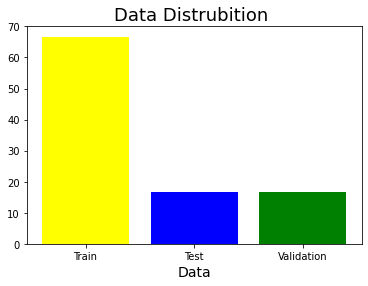

In [15]:
Data_type = ['Train','Test','Validation']
Total_Data = len(train_data)+len(test_data)+len(val_data)
Class_size = [(len(train_data)/Total_Data)*100,(len(test_data)/Total_Data)*100,(len(val_data)/Total_Data)*100]
plt.bar(Data_type, Class_size, color=['yellow','blue','green'])
plt.xlabel('Data', fontsize=14)
plt.title('Data Distrubition ', fontsize=18)
plt.show()

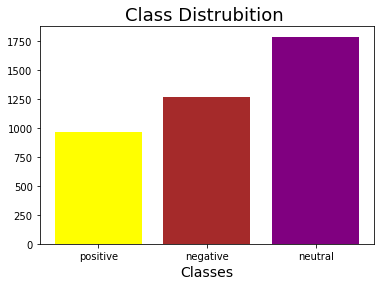

In [16]:
Sentiment_Class = ['positive','negative','neutral']
Class_size = [train_Label.count('positive')+val_Label.count('positive'),
        train_Label.count('negative') +val_Label.count('negative'),
        train_Label.count('neutral') +val_Label.count('neutral')]
plt.bar(Sentiment_Class, Class_size, color=['yellow','brown','purple'])
plt.xlabel('Classes', fontsize=14)
plt.title('Class Distrubition ', fontsize=18)

plt.show()

In [17]:
# Calcualte the Maximum Length 
Extra_Len = 6 
Max_Len = train_data['label'].str.split().str.len().max() + Extra_Len

##Prepare the data

In [18]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [19]:
# 
train_data.to_csv('data/train.csv',index=False)
test_data.to_csv('data/test.csv',index=False)
val_data.to_csv('data/dev.csv',index=False)
# 
label_map = {'positive':1,'negative':-1,'neutral':0}
# 
with open('data/labels.csv','w') as f:
  f.write("\n".join(train_data['label'].unique()))

# BERT Model

# Fast AraBERT
Fine-tune AraBERT with Fast-BERT library
https://github.com/kaushaltrivedi/fast-ber

In [23]:
import logging
from transformers import AutoTokenizer
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
from fast_bert.prediction import BertClassificationPredictor

##Tokenize the Data Set

![](https://miro.medium.com/max/875/0*m_kXt3uqZH9e7H4w.png)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabert')
# 
print('Vocabulary Size\t',tokenizer.vocab_size)
print('Model Length Size',tokenizer.model_max_length)
print('Model Token')
tokenizer.special_tokens_map

Vocabulary Size	 64000
Model Length Size 512
Model Token


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

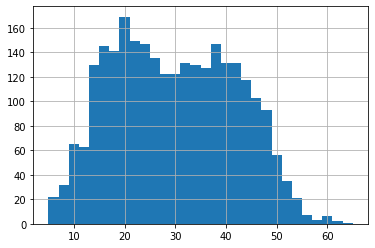

In [21]:
# get length of all the messages in the train set
seq_len = [len(tokenizer.encode(i)) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

## Pretraining Phase

Create a DataBunch Object

In [24]:
databunch = BertDataBunch('./data/', './data/',
                          tokenizer=tokenizer,
                          train_file='train.csv',
                          val_file='dev.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col='label',
                          batch_size_per_gpu=16,
                          max_seq_length=256,
                          multi_gpu=True,
                          multi_label= False,
                          model_type='bert',
                          )



Create the Learner Object


In [32]:
# !mkdir 'output'

In [26]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='aubmindlab/bert-base-arabert',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='output',
						finetuned_wgts_path=None,
						warmup_steps=30,
						multi_gpu=False,
						is_fp16=False,
						multi_label= False,
						logging_steps=0)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

##Fine Tuning

Training

In [27]:
Validation_history = learner.validate()
print(Validation_history['loss'])
print(Validation_history['accuracy'])

1.0579850333077567
0.47313432835820896


In [33]:
learner.fit(epochs=5,
			lr=2e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_linear",
			optimizer_type="adamw")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:257: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(840, 0.47790109450662777)

In [34]:
learner.save_model()

Predictaion

Load the Model

In [35]:
predictor = BertClassificationPredictor(model_path='output/model_out', 
                                        label_path='data', multi_label=False)


Predict 1 sentence

In [36]:
print('Predict this sencnce',test_data.text[2]) 

Predict this sencnce " هذا بيرفكت تقريباسريع رام +ات كبار شاش +ة كبير +ة ويندوز بس في موصف +ات زي مثل +ا شاش +ة لمس و+ منافذ و+ لازم تحطين +ها ف+ ال+ حسبتن "


In [37]:
predictor.predict(test_data.text[1]) , val_data.label[1]

([('negative', 0.9903382658958435),
  ('neutral', 0.00833941251039505),
  ('positive', 0.0013222264824435115)],
 'positive')

Predict Test Data set

In [38]:
def predict_FastArabert(data):
  pred = []
  true = []

  for k in range(len(data.text)):
    prd = predictor.predict(data.text[k])
    true.append(label_map[data.label[k]])
  
    tab = [prd[0][1],prd[1][1],prd[2][1]]
    tab
    max = tab[0]
    indice = prd[0][0]
    for j in range(1,3):
      if tab[j]>max :
        max = tab[j]
        indice = prd[j][0]
    max , indice
    pred.append(label_map[indice])
  return pred
pred = predict_FastArabert(test_data)

In [39]:
test_data['pred Fast arab'] = pred
test_data.head()

,text,label,pred Fast arab
0,""" ? ? منتخب ال+ عراق ال+ طائفي ال+ قميء ترك كل...",negative,-1
1,""" الصرخييردعداعشالتكفيريالدواعش يدع +ون ال+ دف...",negative,-1
2,""" هذا بيرفكت تقريباسريع رام +ات كبار شاش +ة كب...",neutral,0
3,""" هيلاريكلينتون و+ ترامب مختلف +ان ب+ كل شئ ال...",neutral,-1
4,""" أمازون تعتزم افتتاح أول مقر ل+ +ها في ال+ شر...",positive,1


Evaluation

In [35]:
def Accuracy_Loss_Evaluation(Model_Name, True_V, Predict_V):
  #Calculate Acuuracy 
  acc = accuracy_score(True_V,Predict_V)
  print('Accuarcy with ', Model_Name,acc)
  #Calculate Loss 
  Loss = mean_squared_error(True_V,Predict_V)
  print('Loss with ',Model_Name, Loss)
  return acc, Loss

def show_confusion_matrix(True_V,Predict_V):
    cm = confusion_matrix(True_V,Predict_V)
    con_matrix = pd.DataFrame(cm, index=Sentiment_Class, columns=Sentiment_Class)
    hmap = sns.heatmap(con_matrix,annot = True, fmt='' ,cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [44]:
test_data['label_int'] = test_data['label'].apply(lambda x: label_map[x])
acc_FastBert,Loss_FastBert = Accuracy_Loss_Evaluation('Fast AraBert',test_data['label_int'],pred)

Accuarcy with  Fast AraBert 0.6959761549925484
Loss with  Fast AraBert 0.3442622950819672


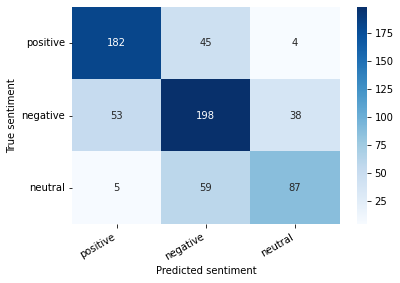

In [49]:
show_confusion_matrix(test_data['label_int'], test_data['pred Fast arab'])

In [51]:
print(classification_report(test_data['label_int'],test_data['pred Fast arab']))

              precision    recall  f1-score   support

          -1       0.76      0.79      0.77       231
           0       0.66      0.69      0.67       289
           1       0.67      0.58      0.62       151

    accuracy                           0.70       671
   macro avg       0.70      0.68      0.69       671
weighted avg       0.70      0.70      0.69       671



In [57]:
#  Remove the column of Fast Bert Predication to use other Model
test_data.drop(columns=['pred Fast arab'])

,text,label,label_int
0,""" ? ? منتخب ال+ عراق ال+ طائفي ال+ قميء ترك كل...",negative,-1
1,""" الصرخييردعداعشالتكفيريالدواعش يدع +ون ال+ دف...",negative,-1
2,""" هذا بيرفكت تقريباسريع رام +ات كبار شاش +ة كب...",neutral,0
3,""" هيلاريكلينتون و+ ترامب مختلف +ان ب+ كل شئ ال...",neutral,0
4,""" أمازون تعتزم افتتاح أول مقر ل+ +ها في ال+ شر...",positive,1
...,...,...,...
666,""" اللهم بشر بشار +ا لأ سد ب+ ال+ نار و+ ال+ دم...",negative,-1
667,""" كيف أقحم +ت ال+ صدف +ة “ دونالد ترامب ” في ك...",neutral,0
668,""" سليماني ال+ سعودي +ة ساوم +ت ال+ أسد """,neutral,0
669,""" سوري +ه مقيم +ة طيب +ة رومانسي +ة عطوف +ة أر...",neutral,0


## Predict Saudi Data set using Fast AraBert



Read the Saudi Dataset

In [52]:
# read by default 1st sheet of an excel file
BankData = pd.read_excel('/data_Saudi_banks.xlsx')
data_bank_distrbuation = BankData['Bank']
# 
# Saudi data PreProcessing
def SaudiData_Preprocessing(data):
  text = []
  for line in data:  
   line = re.sub('[0-9@]', '',line)
   line = re.sub('[/:\._\?]', '',line)
   line = re.sub('[a-zA-z]', '',line)
   line = re.sub('[#[]', '',line)
   line = re.sub(']', '',line)
   line = line.rstrip().lstrip()
   text.append(line)
  return text
Saudi_Text = SaudiData_Preprocessing(BankData['Tweet'])
Saudi_label = BankData['Final annotation']
#Map the label to be same as Model training Label  
Saudi_label = list(map(lambda x: x.replace('POS', 'positive'), Saudi_label))
Saudi_label = list(map(lambda x: x.replace('NEG', 'negative'), Saudi_label))
Saudi_label = list(map(lambda x: x.replace('NEU', 'neutral'), Saudi_label))

In [53]:
# Saudi Data Segmentation 
Saudi_data = pd.DataFrame(data={'text':Saudi_Text,'label':Saudi_label})
Saudi_data['text'] = Saudi_data['text'].apply(lambda x: arabert_prep.preprocess(x) )

Prediaction 

In [54]:
Saudi_pred = predict_FastArabert(Saudi_data)

In [55]:
Saudi_data['pred Saudi'] = Saudi_pred
Saudi_data.head()

,text,label,pred Saudi
0,الله يقلعك من بنك دمر مستقبل +نا الله حسب +نا ...,negative,-1
1,صار لي يوم +ين ب+ حاول أوصل لاي شخص من قبل +كم...,negative,-1
2,صادق كثير من ال+ زملاء يشتكون من +ه ال+ صراحه ...,negative,1
3,ماقدرنا ناخذ ب+ طاق +ه مدى و+ حسابي ذهبي و+ مو...,negative,-1
4,رواتب +هم نص +ها أقساط وش يدور من عروض بعد,negative,0


Evaluation

In [56]:
Saudi_data['label_int'] = Saudi_data['label'].apply(lambda x: label_map[x])
acc_FastBert_Saudi, Loss_FastBert_Saudi = Accuracy_Loss_Evaluation('Fast AraBert',Saudi_data['label_int'],Saudi_pred)

Accuarcy with  Fast AraBert 0.600929614873838
Loss with  Fast AraBert 0.512367197875166


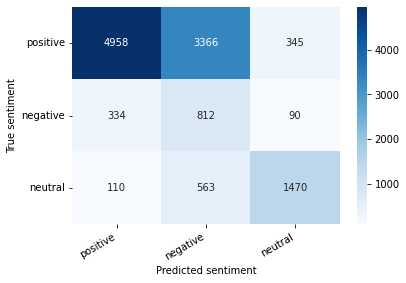

In [58]:
show_confusion_matrix(Saudi_data['label_int'], Saudi_data['pred Saudi'])

In [59]:
print(classification_report(Saudi_data['label_int'],Saudi_data['pred Saudi']))

              precision    recall  f1-score   support

          -1       0.92      0.57      0.70      8669
           0       0.17      0.66      0.27      1236
           1       0.77      0.69      0.73      2143

    accuracy                           0.60     12048
   macro avg       0.62      0.64      0.57     12048
weighted avg       0.82      0.60      0.66     12048



Negative case labeled as Positive 

In [60]:
Saudi_data[Saudi_data['label_int']!= Saudi_data['pred Saudi']].head()

,text,label,pred Saudi,label_int
2,صادق كثير من ال+ زملاء يشتكون من +ه ال+ صراحه ...,negative,1,-1
4,رواتب +هم نص +ها أقساط وش يدور من عروض بعد,negative,0,-1
5,اما كذا و+ أنا اتضجر علي دقيق +ه و+ أنت دقيق +...,negative,0,-1
6,لوسمحتوا قاعد +ين نتصل علي +كم محد يرد عند +ي ...,negative,0,-1
7,لاتورطون مثل +ي ال+ بنوك الثاني +ه أفضل من واق...,negative,0,-1


Positive case labeled as Negative 

In [61]:
Saudi_data[(Saudi_data['label_int']==1) & (Saudi_data['pred Saudi'] == -1)].head()

,text,label,pred Saudi,label_int
408,شكر +ا علي ال+ مماطله يا اسوا بنك تعامل +ت مع +ه,positive,-1,1
2698,تكف +ون يالبنك ال+ أهلي ال+ سعودي يمدحونكم بلك...,positive,-1,1
3211,ابشر ك+ غير +ت +ه و+ رح +ت ل+ ال+ فرنسي ارحم,positive,-1,1
3331,ما أظن في +ه بنك أفضل من ال+ راجحي حالي +ا عيب...,positive,-1,1
3684,ياخي و+ الله إن +كم افخم بنك بس ال+ مشكله +ان ...,positive,-1,1


## Comparision SemEval & Saudi DataSet

In [62]:
Results = pd.DataFrame(data={'SemEval':[acc_FastBert *100,Loss_FastBert],'Saudi':[acc_FastBert_Saudi*100,Loss_FastBert_Saudi]})
Results.index = ['Accuracy', 'Loss']
Results.head()


,SemEval,Saudi
Accuracy,69.597615,60.092961
Loss,0.344262,0.512367


# MarBERT

In [17]:
import random, gc
import numpy as np
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from transformers import Trainer , TrainingArguments
from transformers import  AutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

Define BERT Model Data Set

In [18]:
Model_Used = "UBC-NLP/MARBERT"
Task_Name = "classification"

class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list
        
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)
      
      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [19]:

Rand_Seed = 42 
Use_Train_Extended_Data = True


label_list = ['positive','negative','neutral']
label_map_Mar = {'positive':1,'negative':2,'neutral':0}


data_set = Dataset( "Sem", train_data, val_data, label_list )

train_dataset = BERTModelDataset(train_data['text'].to_list(),
                                 train_data['label'].to_list(),Model_Used,Max_Len,label_map_Mar)

evaluation_dataset = BERTModelDataset(val_data['text'].to_list(),
                                      val_data['label'].to_list(),Model_Used,Max_Len,label_map_Mar)



Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Defining Needed Methods for training and evaluation

In [20]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map_Mar))

def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))

  macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[0,1,2])
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,  
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


Define Training Arguments

In [21]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
if Use_Train_Extended_Data :
    training_args.learning_rate = 1.215e-05 # use this with extended data
else:
    training_args.learning_rate = 1.78255000000000001e-05 # use this with org data  
training_args.fp16 = True
training_args.per_device_train_batch_size = 16 #64 
training_args.per_device_eval_batch_size = 16 # 64 
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 5
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.logging_steps = 200
training_args.save_steps = 100000 
training_args.seed = Rand_Seed 
training_args.disable_tqdm = False

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


 Build Model

In [22]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)

print(training_args.seed)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

42


/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training

In [23]:
print(Max_Len)
print(training_args.learning_rate)
print(training_args.adam_epsilon)
print(training_args.warmup_steps)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2683
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 420
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None

7
1.215e-05
1e-08
0


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=420, training_loss=0.8121030693962461, metrics={'train_runtime': 2000.9921, 'train_samples_per_second': 6.704, 'train_steps_per_second': 0.21, 'total_flos': 48257159163570.0, 'train_loss': 0.8121030693962461, 'epoch': 5.0})

Predication

In [33]:
# first define the predection method
def predict(text, tokenizer):
 
  encoded_review = tokenizer.encode_plus(
    text,
    max_length=Max_Len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True, #True,
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
    

  output = trainer.model(input_ids, attention_mask)
  _, prediction = torch.max(output[0], dim=1)
  return prediction[0]

#then lets play !

tokenizer = AutoTokenizer.from_pretrained(Model_Used)

prediction_list = []
i = 0
for tweet in test_data['text']:
    id = test_data['label'][i]
  
    pre = predict(tweet,tokenizer)
    
    # pre_txt = label_list[pre]
    
    # if pre_txt == 'positive': pre_txt = 1
    # if pre_txt == 'negative': pre_txt = 2
    # if pre_txt == 'neutral': pre_txt = 0
    prediction_list.append(pre)
    
    i = i + 1

loading configuration file https://huggingface.co/UBC-NLP/MARBERT/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/149fd0f2228ba9e18736429c365b97eb4a2af1c198b1e068b99815d78d3d9e25.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11
Model config BertConfig {
  "_name_or_path": "UBC-NLP/MARBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_ty

In [41]:
test_data['pred MarBert'] = [label_list[x] for x in  prediction_list]
test_data.head()

,text,label,pred MarBert,label int
0,""" اردوغان قال ل+ روتا +نا لااستطيع تأيد ال+ ان...",negative,neutral,2
1,""" إيرانالتربويون يحتج +ون في ال+ يومالعالميللم...",negative,neutral,2
2,""" سورياريفدمشقهجوم جديد يشن +ه تنظيمالدولة يست...",negative,neutral,2
3,""" ترامب حاول يبرر فضيح +ت +ه ب+ +ان بيل كلنتون...",neutral,neutral,0
4,""" سوري +ة لافروف و+ ظريف يدعو +ان ل+ حل سياسي ...",neutral,positive,0


Evaluation

In [31]:
test_data['label int'] = test_data['label'].apply(lambda x: label_map_Mar[x])
acc_MarBert,Loss_MarBert = Accuracy_Loss_Evaluation('MarBert',test_data['label int'],prediction_list)


Accuarcy with  MarBert 0.5707898658718331
Loss with  MarBert 1.1087928464977646


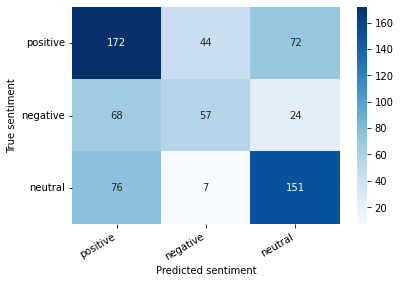

In [37]:
show_confusion_matrix(test_data['label int'], prediction_list)

MisMatch Data

Neutral Case labeled as Positive




In [44]:
test_data[(test_data['label']=='neutral') & (test_data['pred MarBert'] == 'positive')].head()

,text,label,pred MarBert,label int
4,""" سوري +ة لافروف و+ ظريف يدعو +ان ل+ حل سياسي ...",neutral,positive,0
7,""" اخبار برشلون +ة ال+ يوم ال+ لاعب +ون الذين ل...",neutral,positive,0
8,""" وش اللي معجب ك+ ب+ لورد أوف ذا رينقز ؟ هاري ...",neutral,positive,0
10,""" تر +ا متابع س+ ناب +ه و+ أدري ب+ إن +ه طلع م...",neutral,positive,0
15,""" استعراض ل+ تطبيق ال+ رسام ال+ جديد ل+ نظام و...",neutral,positive,0


Positive Case labeled as Neutral


In [45]:
test_data[(test_data['label']=='positive') & (test_data['pred MarBert'] == 'neutral')].head()

,text,label,pred MarBert,label int
5,""" بشرى حل مشكل +ة جامع خادم ال+ حرم +ين ال+ شر...",positive,neutral,1
14,""" عاجل ال+ يمن - تعرف على أسرع هاتف أندرويد في...",positive,neutral,1
105,""" يعني حيك +ون زي ال+ لورد دارث فيدرر هه """,positive,neutral,1
145,""" ال+ مرصدالايرانياقتصاد | إيران و+ تركيا توقع...",positive,neutral,1
159,""" عاد آجا هتآخذ راح +ت +ها أكثر مع فيدرر ياليت...",positive,neutral,1


In [72]:
#  Remove the column of Fast Bert Predication to use other Model
test_data.drop(columns=['pred MarBert','label int'])

,text,label,label_int,pred AraBert
0,""" اردوغان قال ل+ روتا +نا لااستطيع تأيد ال+ ان...",negative,2,2
1,""" إيرانالتربويون يحتج +ون في ال+ يومالعالميللم...",negative,2,1
2,""" سورياريفدمشقهجوم جديد يشن +ه تنظيمالدولة يست...",negative,2,2
3,""" ترامب حاول يبرر فضيح +ت +ه ب+ +ان بيل كلنتون...",neutral,1,2
4,""" سوري +ة لافروف و+ ظريف يدعو +ان ل+ حل سياسي ...",neutral,1,1
...,...,...,...,...
666,""" افتح +ها كد +ه بس أرجو ك+ - لي +ه افتح +ها ا...",neutral,1,1
667,""" غار +ات روسي +ة على مدين +ة حلب ال+ آنالقصف ...",negative,2,1
668,""" ارتفاع ال+ ديون ال+ سعودي +ة خلال شهر +ا إلى...",negative,2,1
669,""" مقطع روبير +ت دي نيرو ال+ منتشر ب+ ال+ واتس ...",negative,2,1


# AraBERT

In [20]:
from transformers import AutoModel
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import SparseAdam, Adam
import time
import random
import torch

Tokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

Define BERT dataset

In [22]:
# Create a function to tokenize a set of texts
import emoji
import unicodedata
def AraBert_DataSet(data, version="mini"):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i,sent in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=data[i], 
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=Max_Len,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
print('Tokenizing data...')
train_inputs, train_masks = AraBert_DataSet(train_data['text'])
val_inputs, val_masks = AraBert_DataSet(val_data['text'])

Tokenizing data...


Create Data loader

In [24]:
train_data['label'] = train_data['label'].replace(['positive','negative','neutral'],[0,2,1])
val_data['label'] = val_data['label'].replace(['positive','negative','neutral'],[0,2,1])

train_labels = torch.tensor(train_data['label'])
val_labels = torch.tensor(val_data['label'])

# For fine-tuning BERT
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Define model 

In [25]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 3 # 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 52.5 µs


In [26]:

def initialize_model(epochs=4, version="mini"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Define model train and evaluate functions

In [27]:

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Training

In [28]:
Rand_Seed =2020
set_seed(Rand_Seed) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.102620   |     -      |     -     |   4.04   
   1    |   40    |   1.090064   |     -      |     -     |   3.60   
   1    |   60    |   1.098817   |     -      |     -     |   4.36   
   1    |   80    |   1.080568   |     -      |     -     |   4.29   
   1    |   100   |   1.088997   |     -      |     -     |   3.54   
   1    |   120   |   1.070481   |     -      |     -     |   3.56   
   1    |   140   |   1.058441   |     -      |     -     |   4.66   
   1    |   160   |   1.043730   |     -      |     -     |   3.86   
   1    |   167   |   1.099021   |     -      |     -     |   1.24   
----------------------------------------------------------------------
   1    |    -    |   1.080179   |  1.077984  |   47.98   |   34.03  
---------------------------------------------------------------------

Predication 

In [29]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [30]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = AraBert_DataSet(test_data['text'])

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [31]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Get predictions from the probabilities
preds = np.argmax(probs, axis=1)

no-negative tweets ratio  1.0461997019374067


In [32]:
test_data['pred AraBert'] =  preds
test_data.head()

,text,label,pred AraBert
0,""" اردوغان قال ل+ روتا +نا لااستطيع تأيد ال+ ان...",negative,2
1,""" إيرانالتربويون يحتج +ون في ال+ يومالعالميللم...",negative,1
2,""" سورياريفدمشقهجوم جديد يشن +ه تنظيمالدولة يست...",negative,2
3,""" ترامب حاول يبرر فضيح +ت +ه ب+ +ان بيل كلنتون...",neutral,2
4,""" سوري +ة لافروف و+ ظريف يدعو +ان ل+ حل سياسي ...",neutral,1


In [36]:
label_map_ara = {'positive':0,'negative':2,'neutral':1}
test_data['label_int'] = test_data['label'].apply(lambda x: label_map_ara[x])
acc_AraBert,Loss_AraBert = Accuracy_Loss_Evaluation('AraBert',test_data['label_int'],preds)

Accuarcy with  AraBert 0.44709388971684055
Loss with  AraBert 0.5752608047690015


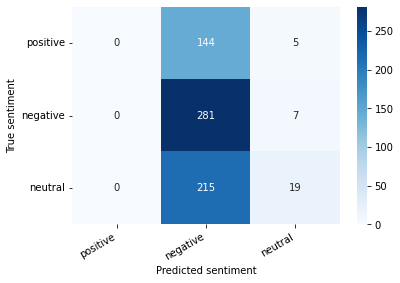

In [37]:
show_confusion_matrix(test_data['label_int'], test_data['pred AraBert'])